This script performs data-processing according to the paper "Particle Mobility Analysis Using Deep Learning and the Moment Scaling Spectrum". 

<a id='Code_overview'></a>
**Code overview:** 

* **Section 1**: [Initialization cells (importing and functions)](#Initialization_cells) 
  <br>Run initialization cells by clicking the *'Run all initialization cells'* button (or by running all cells in **Section 6** ([Initialization code cells](#Initialization_code_cells)) manually). Progress is shown in the progress bar.


* **Section 2**: [Load model](#Load_model)
  <br>Load model of choice.


* **Section 3**: [Loading data, setting parameters and feature vector extraction (multiple real data files)](#Loading_data,_setting_parameters_and_feature_vector_extraction)
  <br>Load the trackfiles for which you want to do data processing. Pixelsize and time step should be set corresponding to parameters of data acquisition. The code will extract the feature vectors for all tracks.


* **Section 4**: [Get predictions/states and properties (D0, D1, D2, fractions)](#Get_predictions/states_and_properties)
  <br>Get all predictions/properties for the specified track files. Required for many plotting options (as indicated).


* **Section 5**: [Plotting](#Plotting)
  <br>Multiple plotting options are available:
    * **Section 5.1**: [Distanceplot with predictions at the bottom (two cells to run: one to select the track and get predictions, one to plot)](#Distanceplot_with_predictions_at_the_bottom)
    <br> Select a track in the first cell and plot predictions in the second cell.
    
    * **Section 5.2**: [Dwell times (from switching tracks, ends discarded)](#Dwell_times)
    <br> Dwell times estimated from switching tracks. <font color='darkorange'>Requires Section 4.</font>
    
    * **Section 5.3**: [Moment scaling spectrum analysis](#Moment_scaling_spectrum_analysis)
    <br> Track analysis using the momentum scaling spectrum (MSS), multiple plots available. <font color='darkorange'>Requires Section 4.</font>
    
      * **Section 5.3.1**: [MSS](#MSS)
      <br> Plot mass scaling spectrum (MSS) for whole tracks and tracklets. Options: gamma vs p, log(Cp) versus p and D vs p.
      * **Section 5.3.2**: [Smss vs D (clusters)](#Smss_vs_D)
      <br> Plot tracklets in Smss-D plane, color coded per state.
      * **Section 5.3.3**: [Kernel density estimation](#Kernel_density_estimation)
      <br> Plot kernel density estimation map for tracklets. <font color='darkorange'>Requires Section 5.3.2.</font> 
      * **Section 5.3.4** [Tracklet overview table](#Overview)
      <br> Properties per tracklet: tracklet number, state, cell number, track number, tracklet length, D and Smss.<br>
    <br>
      
    * **Section 5.4**: [Track composition](#Track_composition)
    <br> Plot histograms of track compositions. <font color='darkorange'>Requires Section 4.</font>
    
    * **Section 5.5**: [Single cell plots](#Single_cell_plots)
    <br> Plots for a selected single cell, multiple plots available. <font color='darkorange'>Requires Section 4.</font>
      * **Section 5.5.1**: [Distribution of only fast / only slow / only immobile / switching tracks in a selected cell](#Distribution_of_only_fast_/_only_slow_/_only_immobile_/_switching_tracks_in_a_selected_cell)
      <br> Cell plot that shows the distribution of different types of tracks in the selected cell (plus histograms).
      * **Section 5.5.2** [Distribution of fast / slow / immobile state in a selected cell](#Distribution_of_fast_/_slow_/_immobile_state_in_a_selected_cell)
      <br> Cell plot that shows the distribution of different states.
      * **Section 5.5.3** [Plot middle fast / slow / immobile state displacements as heatmaps](#Plot_middle_fast_/_slow_/_immobile_state_displacements_as_heatmaps)
      <br> Cell plot that shows a heatmap of different states.

<a id='Initialization_cells'></a>
### Initialization cells (importing and functions)
[Back to code overview](#Code_overview)

In [13]:
# draw a bar that shows that the initialization is finished
from ipywidgets import FloatProgress
from IPython.display import display
initialization_bar = FloatProgress(min = 0, max = 1, description = 'Initializing:', bar_style = 'success')
initialization_bar.value = 0
display(initialization_bar)

FloatProgress(value=0.0, bar_style='success', description='Initializing:', max=1.0)

<a id='Load_model'></a>
### Load model 
[Back to code overview](#Code_overview)

In [16]:
# Load model
pathToModel = os.getcwd() + '/Models/20-5/' # Should always end with /
modelName = \
'Model_Bidirectional_NoShape_3state_Tr10000'

model = keras.models.load_model(pathToModel + modelName)
print('Model loaded')

Model loaded


<a id='Loading_data,_setting_parameters_and_feature_vector_extraction'></a>
### Loading data, setting parameters and feature vector extraction (multiple real data files)
[Back to code overview](#Code_overview)

In [17]:
# Select folder with files that need to be analyzed
pathToFiles = os.getcwd() + '/SpotOnCTCF200HzExpB/SpotOn_CTCF_200Hz_ExpB/' # Should always end with / 

# Set pixelsize [um] and time step [s] corresponding to acquisition parameters
pixSize = 0.160
t = 0.005

# Default: select all files from folder
# If not all files should be selected, provide array with seperate filenames (strings with .txt) from the same folder
filename = []
for file in os.listdir(pathToFiles):
    filename.append(file)
    

##########################################################################################################################


# Parameters for feature extraction (in principle, none of the parameters below ever need to be changed)
addFeat = ['meanMSD', 'xy']
maxOrder = 2
shift = 2
nClasses = 2
min1state = 1

# Data loading and formatting
x = []
y = []
indices = [0]
indfile = 0

for name in filename:
    xfile, yfile = loadRealData(np.loadtxt(pathToFiles + name))
    indfile += len(xfile)
    indices.append(indfile)
    for trackx, tracky in zip(xfile, yfile):
        x.append(trackx)
        y.append(tracky)

# Construction of feature vector
d = getDist(x, y)
featVec = getFeatVec(d, x, y, addFeat, maxOrder, shift)

foldername = pathToFiles[[i for i, j in enumerate(pathToFiles) if j == '/'][-2] + 1:\
                     [i for i, j in enumerate(pathToFiles) if j == '/'][-1]]

print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
print('Data loaded and features extracted')

Folder: SpotOn_CTCF_200Hz_ExpB (19 files) 

Data loaded and features extracted


<a id='Get_predictions/states_and_properties'></a>
### Get predictions/states and properties (D0, D1, D2, fractions)
[Back to code overview](#Code_overview)

In [19]:
# Checkpoints to make sure all required cells have been run
if modelName == 'Nothing':
    print('Run section 2 first (select model)!')
elif filename == 'Nothing':
    print('Run section 3 first (select files)!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')

    runProp = filename # Checkpoint for plotting functions later on.
    

    # Get predicted states
    reshapedTracks = []
    numFeat = 1 + ('meanMSD' in addFeat) * maxOrder + ('xy' in addFeat) * 4

    print('Model: ' + modelName + '\n')

    allStates = []

    for fv in featVec:
        track = np.array(fv).reshape(1, len(fv), numFeat)
        predicted = model.predict(track)
        predSt = predicted.argmax(axis = 2)

        reshapedTracks.append(track)
        allStates.append(predSt[0])
    
    print('Classification complete')



    # Get lists of distances in state 0, 1 and 2

    state0 = []
    state1 = []
    state2 = []
    state012 = []


    for pred, tr in zip(allStates, reshapedTracks):
        for i in range(len(pred)):
            state012.append(tr[0][i][0])

            if pred[i] == 0:
                state0.append(tr[0][i][0])
            elif pred[i] == 1:
                state1.append(tr[0][i][0])
            else:
                state2.append(tr[0][i][0])

    state0 = np.sort(state0)
    state1 = np.sort(state1)
    state2 = np.sort(state2)
    state012 = np.sort(state012)


    # Calculate D0, D1 and D2 from state0, state1 and state2

    mean0 = ((pixSize * np.array(state0)) ** 2).mean()
    mean1 = ((pixSize * np.array(state1)) ** 2).mean()
    mean2 = ((pixSize * np.array(state2)) ** 2).mean()
    
    # Brownian motion: D = (mean(d^2)) / (4 * time step)
    D0 = mean0 / (4 * t) 
    D1 = mean1 / (4 * t)
    D2 = mean2 / (4 * t) 

    print('Brownian motion: D0 (fast): %.6f, D1 (slow): %.6f, D2 (immobile): %.6f\
    \t(D = (mean(d^2) / (4 * time step))' %(D0, D1, D2))

    # Rayleigh: D = mean(d)^2 / (pi * time step)
    DD0 = (np.array(state0).mean() * pixSize) ** 2 / math.pi / t # (Rayleigh)
    DD1 = (np.array(state1).mean() * pixSize) ** 2 / math.pi / t # (Rayleigh)
    DD2 = (np.array(state2).mean() * pixSize) ** 2 / math.pi / t # (Rayleigh)

    print('Rayleigh:\t D0 (fast): %.6f, D1 (slow): %.6f, D2 (immobile): %.6f\
    \t(D = mean(d)^2 / (pi * time step))\n' %(DD0, DD1, DD2))
    
    
    # Get probability transition matrix P = P[[p00, p01], [p10, p11]]

    Step00 = 0
    Step01 = 0
    Step02 = 0
    Step10 = 0
    Step11 = 0
    Step12 = 0
    Step20 = 0
    Step21 = 0
    Step22 = 0

    for pred in allStates:
        for i in range(len(pred) - 1):
            if pred[i] == 0:
                if pred[i + 1] == 0:
                    Step00 += 1
                elif pred[i + 1] == 1:
                    Step01 += 1
                elif pred[i + 1] == 2:
                    Step02 += 1
            elif pred[i] == 1:
                if pred[i + 1] == 0:
                    Step10 += 1
                elif pred[i + 1] == 1:
                    Step11 += 1
                elif pred[i + 1] == 2:
                    Step12 += 1
            elif pred[i] == 2:
                if pred[i + 1] == 0:
                    Step20 += 1
                elif pred[i + 1] == 1:
                    Step21 += 1
                elif pred[i + 1] == 2:
                    Step22 += 1

    p00 = round(Step00 / (Step00 + Step01 + Step02), 3)
    p01 = round(Step01 / (Step00 + Step01 + Step02), 3)
    p02 = round(Step02 / (Step00 + Step01 + Step02), 3)
    p10 = round(Step10 / (Step10 + Step11 + Step12), 3)
    p11 = round(Step11 / (Step10 + Step11 + Step12), 3)
    p12 = round(Step12 / (Step10 + Step11 + Step12), 3)
    p20 = round(Step20 / (Step20 + Step21 + Step22), 3)
    p21 = round(Step21 / (Step20 + Step21 + Step22), 3)
    p22 = round(Step22 / (Step20 + Step21 + Step22), 3)
    
    P = [[p00, p01, p02], [p10, p11, p12], [p20, p21, p22]]
    print('Probability transition matrix:\n' + str(np.matrix(P).reshape((3,3))) + '\n')


    # Calculate fraction of timepoints spent in state 0/1/2

    st0 = 0
    st1 = 0
    st2 = 0

    for pred in allStates:
        for i in range(len(pred) - 1):
            if pred[i] == 0:
                st0 += 1
            elif pred[i] == 1:
                st1 += 1
            else:
                st2 += 1

    frac0 = st0 / (st0 + st1 + st2)
    frac1 = st1 / (st0 + st1 + st2)
    frac2 = st2 / (st0 + st1 + st2)

    print('Fast fraction:\t\t%.6f\nSlow fraction:\t\t%.6f\nImmobile fraction:\t%.6f\n' %(frac0, frac1, frac2))


Folder: SpotOn_CTCF_200Hz_ExpB (19 files) 

Model: Model_Bidirectional_NoShape_3state_Tr10000

Classification done
Brownian motion: D0 (fast): 6.009009, D1 (slow): 1.380522, D2 (immobile): 0.250719    	(D = (mean(d^2) / (4 * time step))
Rayleigh:	 D0 (fast): 5.979368, D1 (slow): 1.369723, D2 (immobile): 0.246726    	(D = mean(d)^2 / (pi * time step))

Probability transition matrix:
[[ 0.75   0.13   0.12 ]
 [ 0.05   0.862  0.088]
 [ 0.002  0.029  0.97 ]]

Fast fraction:		0.090044
Slow fraction:		0.183233
Immobile fraction:	0.726723



<a id='Plotting'></a>
### Plotting
[Back to code overview](#Code_overview)

<a id='Distanceplot_with_predictions_at_the_bottom'></a>
#### Distanceplot with predictions at the bottom (two cells to run: one to select the track and get predictions, one to plot)
[Back to code overview](#Code_overview)

In [60]:
# Checkpoints to make sure all required cells have been run
if modelName == 'Nothing':
    print('Run section 2 first (select model)!')
elif filename == 'Nothing':
    print('Run section 3 first (load data)!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
    
    # Get predicted states for a certain tracknumber.
    # For first try, trackNum = 0 should be uncommented and trackNum = trackNum + 1 should be commented 
    # (to find first track > minLen).
    # Comment trackNum = 0 and uncomment trackNum = trackNum + 1 after first try (to find next track > minLen).

    trackNum = 3
#     trackNum = trackNum + 1
    minLen = 50

#     while len(featVec[trackNum]) < minLen:
#         trackNum += 1

#     trackSize = minLen # Select this option if you want only the first minLen number of displacements of the track
    trackSize = len(featVec[trackNum]) # Select this option if you want the whole track

    numFeat = 1 + ('meanMSD' in addFeat) * maxOrder + ('xy' in addFeat) * 4

    testTrack = np.array(featVec[trackNum][:trackSize]).reshape(1, trackSize, numFeat)

    predicted = model.predict(testTrack)
    predStates = predicted.argmax(axis = 2)

    print('Track number: %s, track length: %s\n' %(trackNum, trackSize))

    print('State 0 = fast, state 1 = slow, state 2 = immobile\n')

    print('Predicted states:\n%s' %(predStates[0]))

    runCompare = filename

Folder: WT_-IR (22 files) 

Track number: 3, track length: 44

State 0 = fast, state 1 = slow, state 2 = immobile

Predicted states:
[2 2 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]


Folder: WT_-IR (22 files) 

Track number: 30, track length: 59



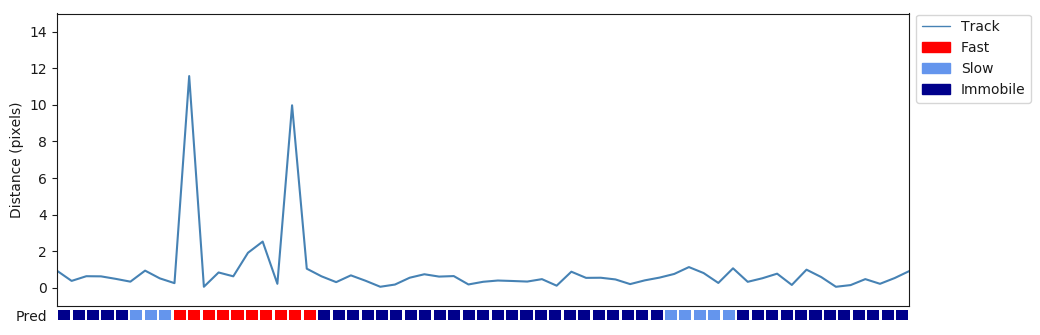

In [24]:
if runCompare != filename:
    print('Run previous cell first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
    
    distVec = d[trackNum][:trackSize]
    print('Track number: %s, track length: %s\n' %(trackNum, trackSize))

    maxRow = 20
    ymax = 15

    colors1 = ['red', 'cornflowerblue', 'darkblue']
    cmap1 = matplotlib.colors.ListedColormap(colors1)
    
    blue_line = mlines.Line2D([], [], color = 'steelblue', label = 'Track')
    red_patch = mpatches.Patch(color = 'red', label = 'Fast')
    cornflowerblue_patch = mpatches.Patch(color = 'cornflowerblue', label = 'Slow')
    darkblue_patch = mpatches.Patch(color = 'darkblue', label = 'Immobile')

    sns.set(font_scale = 1.1)

    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (round(trackSize / 5.5), 4)
    
    plt.subplot2grid((maxRow, 1), (0, 0), rowspan = maxRow - 1)
    plt.plot(np.arange(trackSize), distVec, 'steelblue')
    plt.ylabel('Distance (pixels)')
    plt.xticks([], [])
    ax1 = plt.gca()
    ax1.set_xlim([0, trackSize - 1])
    ax1.set_ylim([-1, ymax])

    plt.legend(handles = [blue_line, red_patch, cornflowerblue_patch, darkblue_patch], \
               loc = 'upper left', bbox_to_anchor = (1, 1.02), fontsize = 'medium')

    plt.subplot2grid((maxRow, 1), (maxRow - 1, 0), rowspan = 1)
    ax2 = sns.heatmap([predStates[0]], annot = False, linewidths = 1, cbar = False,\
                     xticklabels = False, yticklabels = True, cmap = cmap1, vmin = 0, vmax = 2)
    ax2.set_yticklabels(['Pred'], rotation = 0)
    ax2.yaxis.set_ticks_position('none') 

    plt.show()

<a id='Dwell_times'></a>
#### Dwell times (from switching tracks, ends discarded)
[Back to code overview](#Code_overview)

Folder: SpotOn_CTCF_200Hz_ExpB (19 files) 

Number of trackpieces used fast state:		847
Number of trackpieces used slow state:		1456
Number of trackpieces used immobile state:	1324

Mean dwell time fast state:	0.0097 sec
Mean dwell time slow state:	0.0143 sec
Mean dwell time immobile state:	0.0154 sec


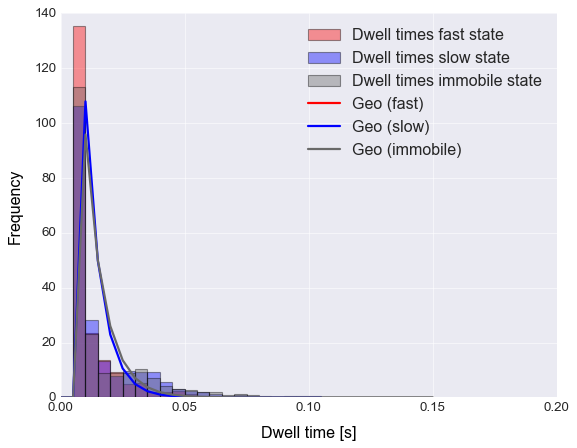

In [22]:
if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')

    switchTr = []

    for i in range(len(allStates)):
        if list(allStates[i]).count(allStates[i][0]) !=  len(allStates[i]):
            switchTr.append(allStates[i])

    toAnalyze0 = []
    toAnalyze1 = []
    toAnalyze2 = []

    for track in switchTr:
        sw = 0
        swList = []
        while list(track)[sw:].count(track[sw]) != len(track[sw:]):
            sw = next(ind for ind in range(sw + 1, len(track)) if track[ind] != track[sw])
            swList.append(sw)


        if len(swList) > 1:
            for sl in range(len(swList[:-1])):
                if track[swList[sl]] == 0:
                    toAnalyze0.append(swList[sl + 1] - swList[sl])
                elif track[swList[sl]] == 1:
                    toAnalyze1.append(swList[sl + 1] - swList[sl])
                else:
                    toAnalyze2.append(swList[sl + 1] - swList[sl])

    print('Number of trackpieces used fast state:\t\t' + str(len(toAnalyze0)))
    print('Number of trackpieces used slow state:\t\t' + str(len(toAnalyze1)))
    print('Number of trackpieces used immobile state:\t' + str(len(toAnalyze2)) + '\n')

    print('Mean dwell time fast state:\t%.4f sec' %(np.array(toAnalyze0).mean() * t))
    print('Mean dwell time slow state:\t%.4f sec' %(np.array(toAnalyze1).mean() * t))
    print('Mean dwell time immobile state:\t%.4f sec' %(np.array(toAnalyze2).mean() * t))

    plt.style.use(['classic', 'seaborn-darkgrid'])
    plt.rcParams['figure.figsize'] = (8, 6)

    maxL = max(toAnalyze0 + toAnalyze1 + toAnalyze2) * t
    binwidth = t

    plt.figure()
    plt.hist(np.array(toAnalyze0) * t, np.arange(0, maxL + binwidth, binwidth), density = True, color = 'red', \
             alpha = 0.4, label = 'Dwell times fast state')
    plt.hist(np.array(toAnalyze1) * t, np.arange(0, maxL + binwidth, binwidth), density = True, color = 'blue', \
             alpha = 0.4, label = 'Dwell times slow state')
    plt.hist(np.array(toAnalyze2) * t, np.arange(0, maxL + binwidth, binwidth), density = True, color = 'dimgrey', \
             alpha = 0.4, label = 'Dwell times immobile state')
    

    from scipy.stats import geom
    geo0 = geom.pmf(np.arange(0, max(toAnalyze0) + 1), 1 / ((np.array(toAnalyze0) - min1state).mean()), loc = min1state)
    geo1 = geom.pmf(np.arange(0, max(toAnalyze1) + 1), 1 / ((np.array(toAnalyze1) - min1state).mean()), loc = min1state)
    geo2 = geom.pmf(np.arange(0, max(toAnalyze2) + 1), 1 / ((np.array(toAnalyze2) - min1state).mean()), loc = min1state)
    plt.plot(np.arange(0, max(toAnalyze0) + 1) * t, geo0 / t, 'r', linewidth = 2, label = 'Geo (fast)')
    plt.plot(np.arange(0, max(toAnalyze1) + 1) * t, geo1 / t, 'blue', linewidth = 2, label = 'Geo (slow)')
    plt.plot(np.arange(0, max(toAnalyze2) + 1) * t, geo2 / t, 'dimgrey', linewidth = 2, label = 'Geo (immobile)')
    
    # Limits on the x-axis can be commented or uncommented (depends on region of interest)
    (plt.gca()).set_xlim(0, 0.2)
    
    handles,labels = (plt.gca()).get_legend_handles_labels()
    handles = [handles[3], handles[4], handles[5], handles[0], handles[1], handles[2]]
    labels = [labels[3], labels[4], labels[5], labels[0], labels[1], labels[2]]
    plt.legend(handles, labels, loc = 'upper right')
    
    plt.xlabel('Dwell time [s]', labelpad = 10, fontdict = font, size = 'large')
    plt.ylabel('Frequency', labelpad = 10, fontdict = font, size = 'large')
    plt.show()

<a id='Moment_scaling_spectrum_analysis'></a>
#### Moment scaling spectrum analysis
[Back to code overview](#Code_overview)

<a id='MSS'></a>
##### MSS
[Back to code overview](#Code_overview)

Folder: SpotOn_CTCF_200Hz_ExpB_SOS (1 files) 

Fast		MSD: D = 47.8289 		MSS: Smss = 0.0948, Intercept = 0.7706
Slow		MSD: D = 1.0841 		MSS: Smss = 0.4094, Intercept = -0.0194
Immobile	MSD: D = 0.0419 		MSS: Smss = 0.2361, Intercept = -0.0819



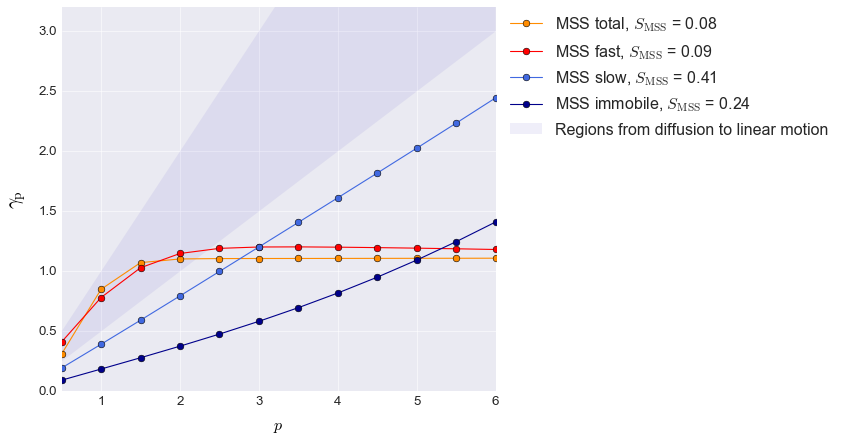

In [76]:
# Three possible plots: gamma versus p, log(Cp) versus p and D versus p
# Specify which plots to produce (by setting True or False):
plotGvsP = True # Plot gamma versus p
plotCvsP = False # Plot log(Cp) versus p
plotDvsP = False # Plot D versus p

if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')

    numPmsd = 4
    numPmss = 4
    minLen = 10
    p = np.linspace(0.5, 6, 12) # power
    b = 'unknown' # b can be set to 'zero' if MSD (ax + b) needs to be calculated with b = 0. Default is b = 'unknown'.

    # Calculations for whole dataset
    goodX = []
    goodY = []
    for xx, yy in zip(x, y):
        if len(xx) > max(numPmsd, numPmss, minLen):
            diff, _, Smss, _ = getMSDandMSS([xx], [yy], numPmsd, numPmss, p, b = b)
            if (diff >= 0) and (Smss >= 0):
                goodX.append(xx)
                goodY.append(yy)
           
    diff, MSS, C, cD, Smss, intercept = getMSDandMSSandC(goodX, goodY, numPmsd, numPmss, p, b = b)

    # Calculations per state
    x0, y0, x1, y1, x2, y2 = getTrackPieces(x, y, allStates)
    
    goodX0 = []
    goodY0 = []
    for xx0, yy0 in zip(x0, y0):
        if len(xx0) > max(numPmsd, numPmss, minLen):
            diff0, _, Smss0, _ = getMSDandMSS([xx0], [yy0], numPmsd, numPmss, p, b = b)
            if (diff0 >= 0) and (Smss0 >= 0):
                goodX0.append(xx0)
                goodY0.append(yy0)

                
    goodX1 = []
    goodY1 = []
    for xx1, yy1 in zip(x1, y1):
        if len(xx1) > max(numPmsd, numPmss, minLen):
            diff1, _, Smss1, _ = getMSDandMSS([xx1], [yy1], numPmsd, numPmss, p, b = b)
            if (diff1 >= 0) and (Smss1 >= 0):
                goodX1.append(xx1)
                goodY1.append(yy1)

                    
    goodX2 = []
    goodY2 = []
    for xx2, yy2 in zip(x2, y2):
        if len(xx2) > max(numPmsd, numPmss, minLen):
            diff2, _, Smss2, _ = getMSDandMSS([xx2], [yy2], numPmsd, numPmss, p, b = b)
            if (diff2 >= 0) and (Smss2 >= 0):
                goodX2.append(xx2)
                goodY2.append(yy2)

    
    diff0, MSS0, C0, cD0, Smss0, intercept0 = getMSDandMSSandC(goodX0, goodY0, numPmsd, numPmss, p, b = b)
    diff1, MSS1, C1, cD1, Smss1, intercept1 = getMSDandMSSandC(goodX1, goodY1, numPmsd, numPmss, p, b = b)
    diff2, MSS2, C2, cD2, Smss2, intercept2 = getMSDandMSSandC(goodX2, goodY2, numPmsd, numPmss, p, b = b)
    print('Fast\t\tMSD: D = %.4f \t\tMSS: Smss = %.4f, Intercept = %.4f' \
          %(diff0, Smss0, intercept0))
    print('Slow\t\tMSD: D = %.4f \t\tMSS: Smss = %.4f, Intercept = %.4f' \
          %(diff1, Smss1, intercept1))
    print('Immobile\tMSD: D = %.4f \t\tMSS: Smss = %.4f, Intercept = %.4f\n' \
          %(diff2, Smss2, intercept2))
    

    # Plotting
    plt.style.use(['classic', 'seaborn-darkgrid'])
    plt.rcParams['figure.figsize'] = (7, 6)
    
    if plotGvsP == True:
        plt.figure(1)
        plt.fill_between(p, p / 2.0, p, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1, \
                         label = 'Regions from diffusion to linear motion')
        plt.plot(p, MSS, '-o', color = 'darkorange', label = r'MSS total, $S_\mathrm{MSS}$ = %.2f' %(Smss))
        plt.plot(p, MSS0, '-o', color = 'red', label = r'MSS fast, $S_\mathrm{MSS}$ = %.2f' %(Smss0))
        plt.plot(p, MSS1, '-o', color = 'royalblue', label = r'MSS slow, $S_\mathrm{MSS}$ = %.2f' %(Smss1))
        plt.plot(p, MSS2, '-o', color = 'darkblue', label = r'MSS immobile, $S_\mathrm{MSS}$ = %.2f' %(Smss2))
        (plt.gca()).set_ylim(0, 3.2)
        (plt.gca()).set_xlim(p[0], p[-1])
        plt.xlabel(r'$p$', labelpad = 10, fontdict = font, size = 'large')
        plt.ylabel(r'$\mathrm{\gamma_p}$', labelpad = 10, fontdict = font, size = 'x-large')
        plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.02))
    
    if plotCvsP == True:
        plt.figure(2)
        plt.plot(p, C, '-o', color = 'darkorange', label = 'Total')
        plt.plot(p, C0, '-o', color = 'red', label = 'Fast')
        plt.plot(p, C1, '-o', color = 'royalblue', label = 'Slow')
        plt.plot(p, C2, '-o', color = 'darkblue', label = 'Immobile')
        (plt.gca()).set_xlim(p[0], p[-1])
        plt.xlabel(r'$p$', labelpad = 10, fontdict = font, size = 'large')
        plt.ylabel(r'$\mathrm{log} \ C_\mathrm{p}$', labelpad = 10, fontdict = font, size = 'large')
        plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.02))
    
    if plotDvsP == True:
        plt.figure(3)
        plt.plot(p, np.array(cD)  * pixSize ** 2 / t, '-o', color = 'darkorange', label = 'Total')
        plt.plot(p, np.array(cD0) * pixSize ** 2 / t, '-o', color = 'red', label = 'Fast')
        plt.plot(p, np.array(cD1) * pixSize ** 2 / t, '-o', color = 'royalblue', label = 'Slow')
        plt.plot(p, np.array(cD2) * pixSize ** 2 / t, '-o', color = 'darkblue', label = 'Immobile')
        (plt.gca()).set_xlim(p[0], p[-1])
        plt.xlabel(r'$p$', labelpad = 10, fontdict = font, size = 'large')
        plt.ylabel(r'$D \ \mathrm{[\mu m^2/s]}$', labelpad = 10, fontdict = font, size = 'large')
        plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.02))
        
    plt.show()

<a id='Smss_vs_D'></a>
##### Smss vs D (clusters)
[Back to code overview](#Code_overview)

Folder: SpotOn_CTCF_200Hz_ExpB (19 files) 



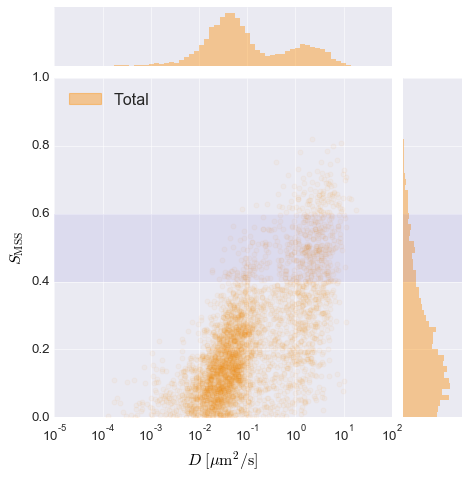

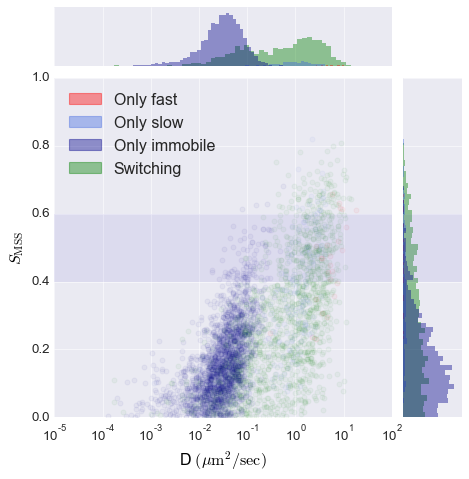

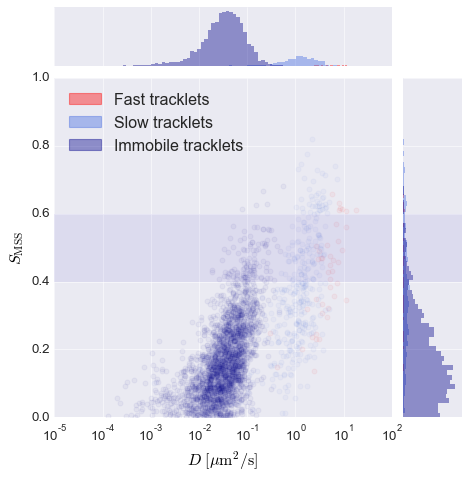

In [20]:
if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
    
    checkClusters = filename

    numPmsd = 4
    numPmss = 4
    minLen = 10
    p = np.linspace(0.5, 6, 12) # power

    # Calculations for whole dataset
    arDiffSw = []
    arSmssSw = []
    arDiffF = []
    arSmssF = []
    arDiffS = []
    arSmssS = []
    arDiffI = []
    arSmssI = []
    for i in range(len(x)):
        if len(x[i]) > max(numPmsd, numPmss, minLen):
            dif, _, smss, _ = getMSDandMSS([x[i]], [y[i]], numPmsd, numPmss, p)
            if (dif >= 0) and (smss >= 0):
                if list(allStates[i]).count(allStates[i][0]) !=  len(allStates[i]):
                    arDiffSw.append(dif)
                    arSmssSw.append(smss)
                elif allStates[i][0] == 0:
                    arDiffF.append(dif)
                    arSmssF.append(smss)
                elif allStates[i][0] == 1:
                    arDiffS.append(dif)
                    arSmssS.append(smss)
                else:
                    arDiffI.append(dif)
                    arSmssI.append(smss)
                
    
    arDiff = arDiffSw + arDiffF + arDiffS + arDiffI
    arSmss = arSmssSw + arSmssF + arSmssS + arSmssI
   
    # Calculations per state
    x0, y0, x1, y1, x2, y2 = getTrackPieces(x, y, allStates)
    
    arDiff0 = []
    arSmss0 = []
    for xx0, yy0 in zip(x0, y0):
        if len(xx0) > max(numPmsd, numPmss, minLen):
            dif0, _, smss0, _ = getMSDandMSS([xx0], [yy0], numPmsd, numPmss, p)
            if dif0 >= 0 and (smss0 >= 0):
                arDiff0.append(dif0)
                arSmss0.append(smss0)

    arDiff1 = []
    arSmss1 = []
    for xx1, yy1 in zip(x1, y1):
        if len(xx1) > max(numPmsd, numPmss, minLen):
            dif1, mss1, smss1, _ = getMSDandMSS([xx1], [yy1], numPmsd, numPmss, p)
            if dif1 >= 0 and (smss1 >= 0):
                arDiff1.append(dif1)
                arSmss1.append(smss1)
                
    arDiff2 = []
    arSmss2 = []
    for xx2, yy2 in zip(x2, y2):
        if len(xx2) > max(numPmsd, numPmss, minLen):
            dif2, mss2, smss2, _ = getMSDandMSS([xx2], [yy2], numPmsd, numPmss, p)
            if dif2 >= 0 and (smss2 >= 0):
                arDiff2.append(dif2)
                arSmss2.append(smss2)
                
    
    plt.style.use(['classic', 'seaborn-darkgrid'])
    plt.rcParams['figure.figsize'] = (12, 6)
    
    # Plot total (whole tracks)
    data = np.column_stack((arDiff, arSmss))
    df = pd.DataFrame(data, columns = [r'$D$ $\mathrm{[\mu m^2/s]}$', r'$S_{\mathrm{MSS}}$'])
    g = sns.JointGrid(r'$D$ $\mathrm{[\mu m^2/s]}$',r'$S_{\mathrm{MSS}}$', data = df)
    
    ax = g.ax_joint
    ax.set_xscale('log')
    g.plot_joint(plt.scatter, color = 'darkorange', alpha = 0.04, edgecolor = 'darkorange')
    ax.axhspan(0.4, 0.6, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1)
    ax.set_ylim(0, 1)
    
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_x.hist(df[r'$D$ $\mathrm{[\mu m^2/s]}$'], color = 'darkorange', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiff)), np.log10(max(arDiff)), 50))
    
    g.ax_marg_y.hist(df[r'$S_{\mathrm{MSS}}$'], color = 'darkorange', edgecolor = 'none', alpha = 0.4, \
                     orientation = 'horizontal', bins = np.linspace(min(arSmss), max(arSmss), 50))
    g.ax_marg_y.axhspan(0.4, 0.6, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1)
    
    orange_patch = mpatches.Patch(color = 'darkorange', alpha = 0.4, label = 'Total')
    ax.legend(handles = [orange_patch], loc = 'upper left')
    plt.xlabel(r'$D$ $\mathrm{[\mu m^2/s]}$', fontdict = font, size = 'large')
    plt.ylabel(r'$S_{\mathrm{MSS}}$', fontdict = font, size = 'large')
    
    
    # Plot per trackstate (whole tracks only fast / only slow / only immobile / switching)
    dataSw = np.column_stack((arDiffSw, arSmssSw))
    dfSw = pd.DataFrame(dataSw, columns = [r'$D$ $\mathrm{[\mu m^2/s]}$', r'$S_{\mathrm{MSS}}$'])
    gSw = sns.JointGrid(r'$D$ $\mathrm{[\mu m^2/s]}$', r'$S_{\mathrm{MSS}}$', data = dfSw)
    
    axSw = gSw.ax_joint
    axSw.set_xscale('log')
    gSw.plot_joint(plt.scatter, color = 'green', alpha = 0.04, edgecolor = 'green')
    axSw.scatter(arDiffF, arSmssF, color = 'r', alpha = 0.04, edgecolor = 'r')
    axSw.scatter(arDiffS, arSmssS, color = 'royalblue', alpha = 0.04, edgecolor = 'royalblue')
    axSw.scatter(arDiffI, arSmssI, color = 'darkblue', alpha = 0.04, edgecolor = 'darkblue')
    axSw.axhspan(0.4, 0.6, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1)
    
    gSw.ax_marg_x.set_xscale('log')
    gSw.ax_marg_x.hist(dfSw[r'$D$ $\mathrm{[\mu m^2/s]}$'], color = 'green', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiffSw)), np.log10(max(arDiffSw)), 50))
    gSw.ax_marg_x.hist(arDiffF, color = 'red', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiffF)), np.log10(max(arDiffF)), 50))
    gSw.ax_marg_x.hist(arDiffS, color = 'royalblue', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiffS)), np.log10(max(arDiffS)), 50))
    gSw.ax_marg_x.hist(arDiffI, color = 'darkblue', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiffI)), np.log10(max(arDiffI)), 50))
    
    gSw.ax_marg_y.hist(dfSw[r'$S_{\mathrm{MSS}}$'], color = 'green', edgecolor = 'none', alpha = 0.4, \
                     orientation = 'horizontal', bins = np.linspace(min(arSmssSw), max(arSmssSw), 50))
    gSw.ax_marg_y.hist(arSmssF, color = 'red', edgecolor = 'none', alpha = 0.4, \
                     orientation = 'horizontal', bins = np.linspace(min(arSmssF), max(arSmssF), 50))
    gSw.ax_marg_y.hist(arSmssS, color = 'royalblue', edgecolor = 'none', alpha = 0.4, \
                     orientation = 'horizontal', bins = np.linspace(min(arSmssS), max(arSmssS), 50))
    gSw.ax_marg_y.hist(arSmssI, color = 'darkblue', edgecolor = 'none', alpha = 0.4, \
                     orientation = 'horizontal', bins = np.linspace(min(arSmssI), max(arSmssI), 50))
    gSw.ax_marg_y.axhspan(0.4, 0.6, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1)
    
    axSw.get_shared_x_axes().join(ax, axSw)
    axSw.autoscale()
    axSw.set_ylim(0, 1)
    
    red_patch = mpatches.Patch(color = 'red', alpha = 0.4, label = 'Only fast')
    royalblue_patch = mpatches.Patch(color = 'royalblue', alpha = 0.4, label = 'Only slow')
    darkblue_patch = mpatches.Patch(color = 'darkblue', alpha = 0.4, label = 'Only immobile')
    green_patch = mpatches.Patch(color = 'green', alpha = 0.4, label = 'Switching')
    axSw.legend(handles = [red_patch, royalblue_patch, darkblue_patch, green_patch], loc = 'upper left')
    plt.xlabel(r'D $\mathrm{(\mu m^2/sec)}$', fontdict = font, size = 'large')
    plt.ylabel(r'$S_{\mathrm{MSS}}$', fontdict = font, size = 'large')
    
    # Plot split (trackpieces fast / slow / immobile)
    data0 = np.column_stack((arDiff0, arSmss0))
    df0 = pd.DataFrame(data0, columns = [r'$D$ $\mathrm{[\mu m^2/s]}$', r'$S_{\mathrm{MSS}}$'])
    f = sns.JointGrid(r'$D$ $\mathrm{[\mu m^2/s]}$', r'$S_{\mathrm{MSS}}$', data = df0)
    
    ax0 = f.ax_joint
    ax0.set_xscale('log')
    f.plot_joint(plt.scatter, color = 'r', alpha = 0.04, edgecolor = 'r')
    ax0.scatter(arDiff1, arSmss1, color = 'royalblue', alpha = 0.04, edgecolor = 'royalblue')
    ax0.scatter(arDiff2, arSmss2, color = 'darkblue', alpha = 0.04, edgecolor = 'darkblue')
    ax0.axhspan(0.4, 0.6, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1)
    
    f.ax_marg_x.set_xscale('log')
    f.ax_marg_x.hist(df0[r'$D$ $\mathrm{[\mu m^2/s]}$'], color = 'red', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiff0)), np.log10(max(arDiff0)), 50))
    f.ax_marg_x.hist(arDiff1, color = 'royalblue', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiff1)), np.log10(max(arDiff1)), 50))
    f.ax_marg_x.hist(arDiff2, color = 'darkblue', edgecolor = 'none', alpha = 0.4, \
                     bins = np.logspace(np.log10(min(arDiff2)), np.log10(max(arDiff2)), 50))
    
    f.ax_marg_y.hist(df0[r'$S_{\mathrm{MSS}}$'], color = 'red', edgecolor = 'none', alpha = 0.4, \
                     orientation = 'horizontal', bins = np.linspace(min(arSmss0), max(arSmss0), 50))
    f.ax_marg_y.hist(arSmss1, color = 'royalblue', edgecolor = 'none', alpha = 0.4, orientation = 'horizontal', \
                     bins = np.linspace(min(arSmss1), max(arSmss1), 50))
    f.ax_marg_y.hist(arSmss2, color = 'darkblue', edgecolor = 'none', alpha = 0.4, orientation = 'horizontal', \
                     bins = np.linspace(min(arSmss2), max(arSmss2), 50))
    f.ax_marg_y.axhspan(0.4, 0.6, facecolor = 'slateblue', edgecolor = 'none', alpha = 0.1)
    
    ax0.get_shared_x_axes().join(ax, ax0)
    ax0.autoscale()
    ax0.set_ylim(0, 1)
    
    red_patch = mpatches.Patch(color = 'red', alpha = 0.4, label = 'Fast tracklets')
    royalblue_patch = mpatches.Patch(color = 'royalblue', alpha = 0.4, label = 'Slow tracklets')
    darkblue_patch = mpatches.Patch(color = 'darkblue', alpha = 0.4, label = 'Immobile tracklets')
    ax0.legend(handles = [red_patch, royalblue_patch, darkblue_patch], loc = 'upper left')
    plt.xlabel(r'$D$ $\mathrm{[\mu m^2/s]}$', fontdict = font, size = 'large')
    plt.ylabel(r'$S_{\mathrm{MSS}}$', fontdict = font, size = 'large')

<a id='Kernel_density_estimation'></a>
##### Kernel density estimation
[Back to code overview](#Code_overview)

Folder: SpotOn_CTCF_200Hz_ExpB (19 files) 



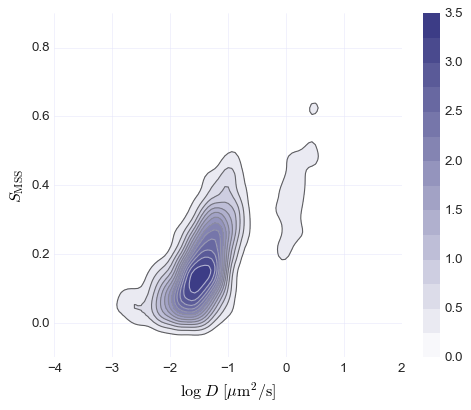

In [21]:
# kde plot contour lines

if checkClusters != filename:
    print('Run Smss vs D (clusters) first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
    
    diffar = arDiff0 + arDiff1 + arDiff2
    smssar = arSmss0 + arSmss1 + arSmss2
    
#     kdemap = cm.Blues # See https://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html for other options.
    kdemap = matplotlib.colors.LinearSegmentedColormap.from_list('kdemap', ['white', 'midnightblue'], N = 100)

    plt.style.use(['classic', 'seaborn-darkgrid'])
    plt.rcParams['figure.figsize'] = (7, 5.38)
    sns.kdeplot(np.log10(diffar), smssar, gridsize = 100, cmap = kdemap, shade = True, shade_lowest = False, \
                n_levels = 15, cbar = True, vmin = 0, vmax = 4)
    sns.kdeplot(np.log10(diffar), smssar, gridsize = 100, shade = False, alpha = 0.6, cmap = cm.gray, n_levels = 15)
    (plt.gca()).set_ylim(-0.1, 0.9)
    (plt.gca()).set_xlim(-4.0, 2.0)
    (plt.gca()).set_facecolor('white')
    (plt.gca()).grid(color='lavender')
    plt.xlabel(r'$\mathrm{log}$ $D$ $\mathrm{[\mu m^2/s]}$', fontdict = font, size = 'large')
    plt.ylabel(r'$S_{\mathrm{MSS}}$', fontdict = font, size = 'large')
    plt.show()

<a id='Overview'></a>
##### Tracklet overview table
[Back to code overview](#Code_overview)

In [80]:
x0, y0, x1, y1, x2, y2, trnums0, trnums1, trnums2 = getTrackPiecesForInfo(x, y, allStates)

numPmsd = 4
numPmss = 4
p = np.linspace(0.5, 6, 12)

info = []

for xx, yy, tn in zip(x0 + x1 + x2, y0 + y1 + y2, trnums0 + trnums1 + trnums2):
    lx = len(xx)
    i = (x0 + x1 + x2).index(xx)
    st = 0 + (i >= len(x0)) * 1 + (i >= len(x0 + x1)) * 1
    
    closest = min(indices, key = lambda x:abs(x-int(np.floor(tn))))
    cn = ((closest - int(np.floor(tn))) < 0) * indices.index(closest) + \
    ((closest - int(np.floor(tn))) > 0) * (indices.index(closest) - 1)
    
    if len(xx) > max(numPmsd, numPmss):
        dif, _, smss, _ = getMSDandMSS([xx], [yy], numPmsd, numPmss, p)
    else:
        dif = '-'
        smss = '-'
    
    info.append([st, cn, tn, lx, dif, smss])
    
colSt = [i[0] for i in info]
colCn = [i[1] for i in info]
colTn = [i[2] for i in info]
colLx = [i[3] for i in info]
colDi = [i[4] for i in info]
colSm = [i[5] for i in info]
    
df = pd.DataFrame({'State' : colSt, \
                   'Cell number' : colCn, \
                   'Track number': colTn, \
                   'Tracklet length': colLx, \
                   'Diffusion constant': colDi, \
                   'Smss': colSm})

dfSorted = df.sort_values(by=['Track number'])
dfSorted.columns.names = ['Tracklet number']

# Save to same folder as data came from (specify other folder if necessary)
dfSorted.to_csv(pathToFiles + 'TrackletOverviewTable.csv')

# Uncomment line below if you want to see a preview of the table
# dfSorted

<a id='Track_composition'></a>
#### Track composition
[Back to code overview](#Code_overview)

Folder: SpotOn_H2B_1ms (17 files) 



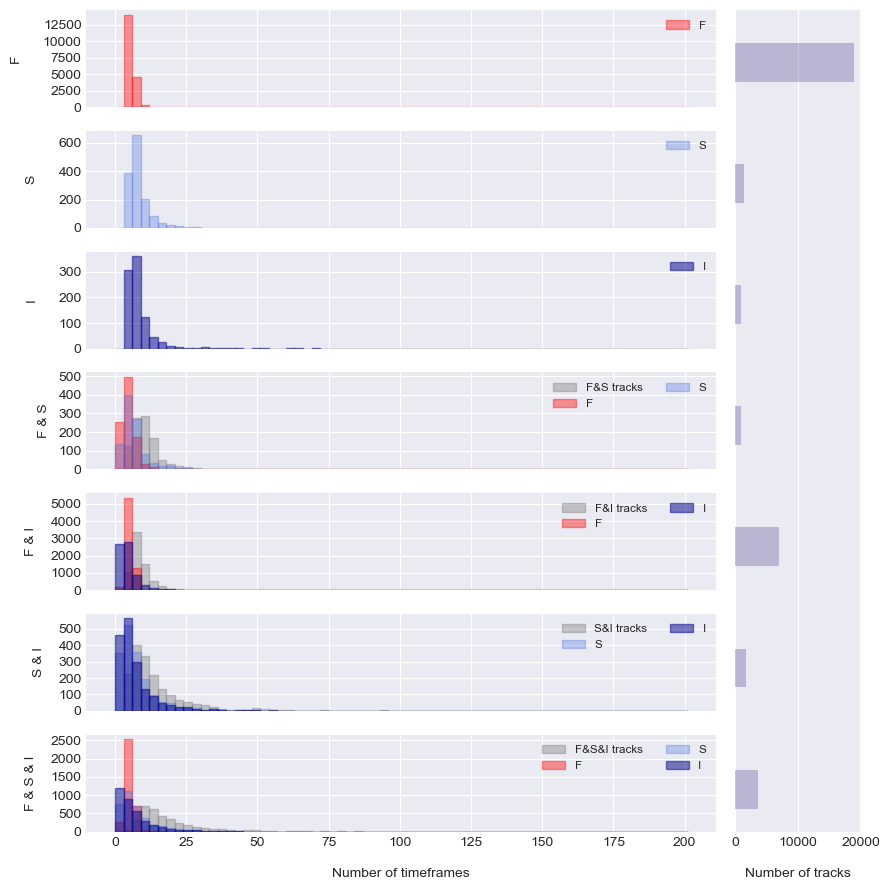

In [22]:
if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')

    F = []
    S = []
    I = []

    FS = []
    FS_f = []
    FS_s = []

    FI = []
    FI_f = []
    FI_i = []

    SI = []
    SI_s = []
    SI_i = []

    FSI = []
    FSI_f = []
    FSI_s = []
    FSI_i = []

    for i in range(len(allStates)):
        if list(allStates[i]).count(allStates[i][0]) !=  len(allStates[i]):
            xS0, yS0, xS1, yS1, xS2, yS2 = getTrackPieces([x[i]], [y[i]], [allStates[i]])

            swind = np.empty(len(x[i]))
            ind0 = patchmatch(x[i], xS0)
            for i0 in ind0:
                swind[i0] = 1
            ind1 = patchmatch(x[i], xS1)
            for i1 in ind1:
                swind[i1] = 2
            ind2 = patchmatch(x[i], xS2)
            for i2 in ind2:
                swind[i2] = 3


            if swind.tolist().count(1) != 0:
                if swind.tolist().count(2) != 0:
                    if swind.tolist().count(3) != 0:
                        FSI.append(len(x[i]))
                        FSI_f.append(sum([len(m) for m in ind0]))
                        FSI_s.append(sum([len(m) for m in ind1]))
                        FSI_i.append(sum([len(m) for m in ind2]))
                    else:
                        FS.append(len(x[i]))
                        FS_f.append(sum([len(m) for m in ind0]))
                        FS_s.append(sum([len(m) for m in ind1]))
                else:
                    FI.append(len(x[i]))
                    FI_f.append(sum([len(m) for m in ind0]))
                    FI_i.append(sum([len(m) for m in ind2]))
            else:
                SI.append(len(x[i]))
                SI_s.append(sum([len(m) for m in ind1]))
                SI_i.append(sum([len(m) for m in ind2]))

        elif allStates[i][0] == 0:
            F.append(len(x[i]))
        elif allStates[i][0] == 1:
            S.append(len(x[i]))
        elif allStates[i][0] == 2:
            I.append(len(x[i]))


    plt.style.use(['default', 'seaborn-darkgrid'])
    plt.rcParams['figure.figsize'] = (9, 9)

    ax1 = plt.subplot2grid((7, 11), (0, 0), colspan = 9)
    ax2 = plt.subplot2grid((7, 11), (1, 0), colspan = 9)
    ax3 = plt.subplot2grid((7, 11), (2, 0), colspan = 9)
    ax4 = plt.subplot2grid((7, 11), (3, 0), colspan = 9)
    ax5 = plt.subplot2grid((7, 11), (4, 0), colspan = 9)
    ax6 = plt.subplot2grid((7, 11), (5, 0), colspan = 9)
    ax7 = plt.subplot2grid((7, 11), (6, 0), colspan = 9)
    ax8 = plt.subplot2grid((7, 11), (0, 9), colspan = 2, rowspan = 7)

    maxL = 200 # max(max(F), max(Ba), max(Bb), max(FBa), max(FBb), max(FBaBb)) if you want to see whole spectrum
    binwidth = 3
    binning = np.arange(0, maxL + binwidth, binwidth)

    ax1.hist(F, bins = binning, color = 'r', alpha = 0.4, label = 'F', edgecolor = 'r')
    ax1.legend(loc = 'upper right', fontsize = 'small', ncol = 1)
    ax1.set_xticklabels([])
    ax1.locator_params(axis = 'y', nbins = 6)
    ax1.set_ylabel('F', labelpad = 15)

    ax2.hist(S, bins = binning, color = 'royalblue', alpha = 0.3, label = 'S', edgecolor = 'royalblue')
    ax2.legend(loc = 'upper right', fontsize = 'small', ncol = 1)
    ax2.set_xticklabels([])
    ax2.locator_params(axis = 'y', nbins = 6)
    ax2.set_ylabel('S', labelpad = 15)

    ax3.hist(I, bins = binning, color = 'darkblue', alpha = 0.5, label = 'I', edgecolor = 'darkblue')
    ax3.legend(loc = 'upper right', fontsize = 'small', ncol = 1)
    ax3.set_xticklabels([])
    ax3.locator_params(axis = 'y', nbins = 6)
    ax3.set_ylabel('I', labelpad = 15)

    ax4.hist(FS, bins = binning, color = 'grey', alpha = 0.4, label = 'F&S tracks', edgecolor = 'grey')
    ax4.hist(FS_f, bins = binning, color = 'r', alpha = 0.4, label = 'F', edgecolor = 'r')
    ax4.hist(FS_s, bins = binning, color = 'royalblue', alpha = 0.3, label = 'S', edgecolor = 'royalblue')
    ax4.legend(loc = 'upper right', fontsize = 'small', ncol = 2)
    ax4.set_xticklabels([])
    ax4.locator_params(axis = 'y', nbins = 6)
    ax4.set_ylabel('F & S', labelpad = 6)

    ax5.hist(FI, bins = binning, color = 'grey', alpha = 0.4, label = 'F&I tracks', edgecolor = 'grey')
    ax5.hist(FI_f, bins = binning, color = 'r', alpha = 0.4, label = 'F', edgecolor = 'r')
    ax5.hist(FI_i, bins = binning, color = 'darkblue', alpha = 0.5, label = 'I', edgecolor = 'darkblue')
    ax5.legend(loc = 'upper right', fontsize = 'small', ncol = 2)
    ax5.set_xticklabels([])
    ax5.locator_params(axis = 'y', nbins = 6)
    ax5.set_ylabel('F & I', labelpad = 10)

    ax6.hist(SI, bins = binning, color = 'grey', alpha = 0.4, label = 'S&I tracks', edgecolor = 'grey')
    ax6.hist(SI_s, bins = binning, color = 'royalblue', alpha = 0.3, label = 'S', edgecolor = 'royalblue')
    ax6.hist(SI_i, bins = binning, color = 'darkblue', alpha = 0.5, label = 'I', edgecolor = 'darkblue')
    ax6.legend(loc = 'upper right', fontsize = 'small', ncol = 2)
    ax6.set_xticklabels([])
    ax6.locator_params(axis = 'y', nbins = 6)
    ax6.set_ylabel('S & I', labelpad = 10)

    ax7.hist(FSI, bins = binning, color = 'grey', alpha = 0.4, label = 'F&S&I tracks', edgecolor = 'grey')
    ax7.hist(FSI_f, bins = binning, color = 'r', alpha = 0.4, label = 'F', edgecolor = 'r')
    ax7.hist(FSI_s, bins = binning, color = 'royalblue', alpha = 0.3, label = 'S', edgecolor = 'royalblue')
    ax7.hist(FSI_i, bins = binning, color = 'darkblue', alpha = 0.5, label = 'I', edgecolor = 'darkblue')
    ax7.legend(loc = 'upper right', fontsize = 'small', ncol = 2)
    ax7.locator_params(axis = 'y', nbins = 6)
    ax7.set_ylabel('F & S & I', labelpad = 10)
    ax7.set_xlabel('Number of timeframes', labelpad = 14)

    forax8 = [len(F), len(S), len(I), len(FS), len(FI), len(SI), len(FSI)]
    ax8.barh(np.arange(7), forax8[::-1], color = 'darkslateblue', alpha = 0.3, log = False, align = 'edge', height = 0.32, tick_label = None)
    ax8.set_ylim(-0.19, 6.59)
    ax8.set_yticks([])
    ax8.set_xlabel('Number of tracks', labelpad = 14)

    plt.tight_layout()
    plt.show()

<a id='Single_cell_plots'></a>
#### Single cell plots
[Back to code overview](#Code_overview)

<a id='Distribution_of_only_fast_/_only_slow_/_only_immobile_/_switching_tracks_in_a_selected_cell'></a>
##### Distribution of only fast / only slow / only immobile / switching tracks in a selected cell
[Back to code overview](#Code_overview)

Folder: SpotOn_CTCF_200Hz_ExpB_SOS (1 files) 



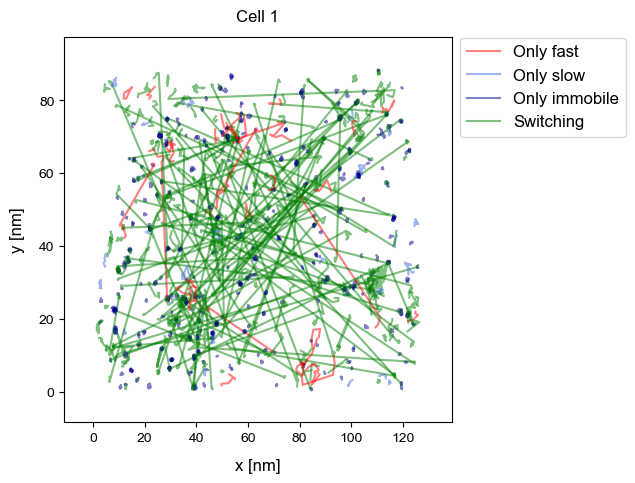

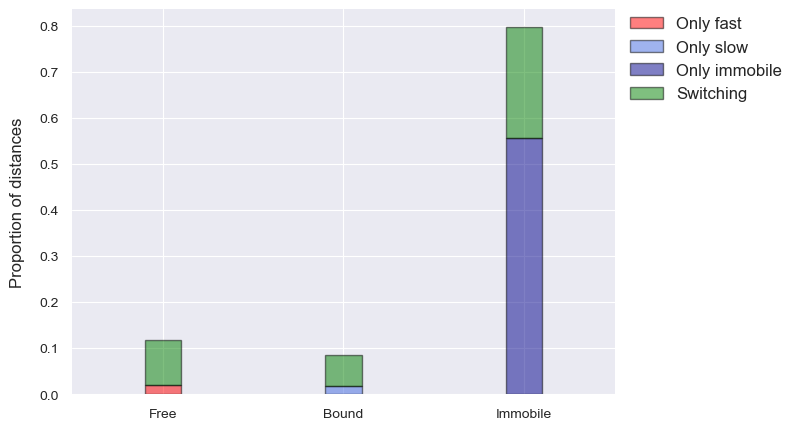

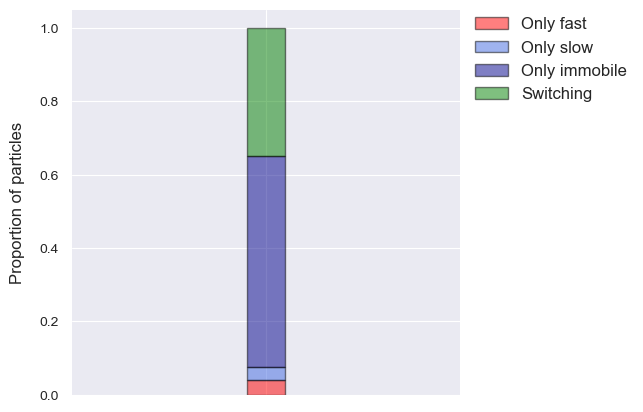

In [81]:
if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')

    # Select the cell that you want to plot.
    # Counting starts from 0 (exmample: if folder contains 20 files, you can select 0-19).
    selectCell = 0
    
    if selectCell >= len(filename):
        print('Selected cell number is too high! There are only ' + str(len(filename)) + ' files in this folder.')
    else:

        plt.style.use('default')
        plt.rcParams['figure.figsize'] = (5, 5)

        colorlabel = 'color'

        countFSw = 0
        countSSw = 0
        countISw = 0
        countF = 0
        countS = 0
        countI = 0
        tracksSw = 0
        tracksF = 0
        tracksS = 0
        tracksI = 0

        plt.figure(1)
        for i in range(len(allStates[indices[selectCell]:indices[selectCell + 1]])):
            if list(allStates[indices[selectCell]:indices[selectCell + 1]][i]).\
            count(allStates[indices[selectCell]:indices[selectCell + 1]][i][0]) !=  \
            len(allStates[indices[selectCell]:indices[selectCell + 1]][i]):
                colorlabel = 'g'
                tracksSw += 1
                countFSw += list(allStates[indices[selectCell]:indices[selectCell + 1]][i]).count(0)
                countSSw += list(allStates[indices[selectCell]:indices[selectCell + 1]][i]).count(1)
                countISw += list(allStates[indices[selectCell]:indices[selectCell + 1]][i]).count(2)
            else:
                if allStates[indices[selectCell]:indices[selectCell + 1]][i][0] == 0:
                    colorlabel = 'r'
                    tracksF += 1
                    countF += len(allStates[indices[selectCell]:indices[selectCell + 1]][i])
                elif allStates[indices[selectCell]:indices[selectCell + 1]][i][0] == 1:
                    colorlabel = 'royalblue'
                    tracksS += 1
                    countS += len(allStates[indices[selectCell]:indices[selectCell + 1]][i])
                else:
                    colorlabel = 'darkblue'
                    tracksI += 1
                    countI += len(allStates[indices[selectCell]:indices[selectCell + 1]][i])

            plt.plot(x[indices[selectCell]:indices[selectCell + 1]][i], \
                     y[indices[selectCell]:indices[selectCell + 1]][i], colorlabel, alpha = 0.5)
            plt.title('Cell ' + str(selectCell + 1), y = 1.02)

        red_line = mlines.Line2D([], [], color = 'r', alpha = 0.5, label = 'Only fast')
        royalblue_line = mlines.Line2D([], [], color = 'royalblue', alpha = 0.5, label = 'Only slow')
        darkblue_line = mlines.Line2D([], [], color = 'darkblue', alpha = 0.5, label = 'Only immobile')
        green_line = mlines.Line2D([], [], color = 'g', alpha = 0.5, label = 'Switching')
        plt.legend(handles = [red_line, royalblue_line, darkblue_line, green_line], \
                   loc = 'upper left', bbox_to_anchor = (1, 1.02), fontsize = 'large')
        plt.xlabel('x [nm]', size = 'large', labelpad = 10)
        plt.ylabel('y [nm]', size = 'large', labelpad = 10)
        plt.margins(0.1)

        plt.style.use(['seaborn-darkgrid'])
        plt.rcParams['figure.figsize'] = (7, 5)

        plt.figure(2)
        countT = countF + countS + countI + countFSw + countSSw + countISw
        plt.bar(1, countF / countT, width = 0.4, color = 'r', alpha = 0.5, edgecolor = 'k', label = 'Only fast', \
                align = 'center')
        plt.bar(3, countS / countT, width = 0.4, color = 'royalblue', alpha = 0.5, edgecolor = 'k', label = 'Only slow', \
                align = 'center')
        plt.bar(5, countI / countT, width = 0.4, color = 'darkblue', alpha = 0.5, edgecolor = 'k', label = 'Only immobile', \
                align = 'center')
        plt.bar(1, countFSw / countT, width = 0.4, bottom = countF / countT, color = 'g', alpha = 0.5, edgecolor = 'k', \
                label = 'Switching', align = 'center')
        plt.bar(3, countSSw / countT, width = 0.4, bottom = countS / countT, color = 'g', alpha = 0.5, edgecolor = 'k', \
                align = 'center')
        plt.bar(5, countISw / countT, width = 0.4, bottom = countI / countT, color = 'g', alpha = 0.5, edgecolor = 'k', \
                align = 'center')
        plt.xticks([1, 3, 5], ('Free', 'Bound', 'Immobile'))
        (plt.gca()).set_xlim(0, 6)
        (plt.gca()).tick_params(pad = 10)
        plt.ylabel('Proportion of distances', labelpad = 10, fontsize = 'large')
        plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.02), fontsize = 'large')

        plt.rcParams['figure.figsize'] = (5, 5)

        plt.figure(3)
        tracksT = tracksSw + tracksF + tracksS + tracksI
        plt.bar(2, tracksF / tracksT, width = 0.4, color = 'r', alpha = 0.5, edgecolor = 'k', label = 'Only fast', \
                align = 'center')
        plt.bar(2, tracksS / tracksT, bottom = tracksF / tracksT, width = 0.4, color = 'royalblue', alpha = 0.5, \
                edgecolor = 'k', label = 'Only slow', align = 'center')
        plt.bar(2, tracksI / tracksT, bottom = (tracksF + tracksS) / tracksT, width = 0.4, color = 'darkblue', alpha = 0.5, \
                edgecolor = 'k', label = 'Only immobile', align = 'center')
        plt.bar(2, tracksSw / tracksT, bottom = (tracksF + tracksS + tracksI) / tracksT, width = 0.4, color = 'g', \
                alpha = 0.5, edgecolor = 'k', label = 'Switching', align = 'center')
        plt.xticks([2], (''))
        (plt.gca()).set_xlim(0, 4)
        (plt.gca()).tick_params(pad = 10)
        plt.ylabel('Proportion of particles', labelpad = 10, fontsize = 'large')
        plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1.02), fontsize = 'large')

        plt.show()

<a id='Distribution_of_fast_/_slow_/_immobile_state_in_a_selected_cell'></a>
##### Distribution of fast / slow / immobile state in a selected cell
[Back to code overview](#Code_overview)

Folder: SpotOn_CTCF_200Hz_ExpB (19 files) 



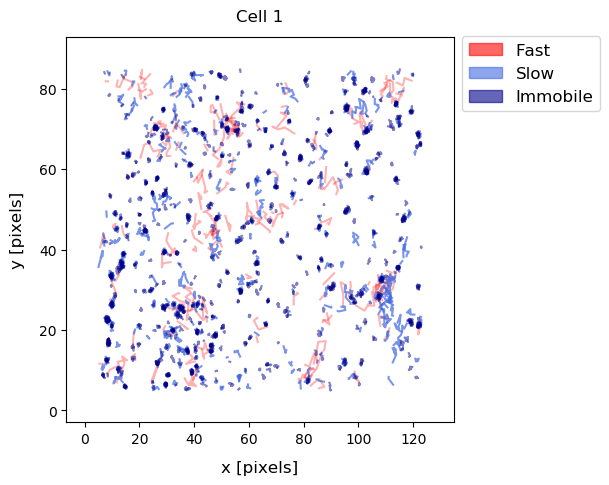

In [39]:
if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
    
    # Select the cell that you want to plot.
    # Counting starts from 0 (exmample: if folder contains 20 files, you can select 0-19).
    selectCell = 0
    
    if selectCell >= len(filename):
        print('Selected cell number is too high! There are only ' + str(len(filename)) + ' files in this folder.')
    else:
        selx0, sely0, selx1, sely1, selx2, sely2 = getTrackPieces(x[indices[selectCell]:indices[selectCell + 1]], \
                                                y[indices[selectCell]:indices[selectCell + 1]], \
                                                allStates[indices[selectCell]:indices[selectCell + 1]])

        plt.style.use('default')
        plt.rcParams['figure.figsize'] = (5, 5)
        
        minimum = 0
        for xx0, yy0 in zip(selx0, sely0):
            if len(xx0) > minimum:
                plt.plot(xx0, yy0, 'r', alpha = 0.3)
        for xx1, yy1 in zip(selx1, sely1):
            if len(xx1) > minimum:
                plt.plot(xx1, yy1, 'royalblue', alpha = 0.7)
        for xx2, yy2 in zip(selx2, sely2):
            if len(xx2) > minimum:
                plt.plot(xx2, yy2, 'darkblue', alpha = 0.5)

        red_patch = mpatches.Patch(color = 'red', alpha = 0.6, label = 'Fast')
        royalblue_patch = mpatches.Patch(color = 'royalblue', alpha = 0.6, label = 'Slow')
        darkblue_patch = mpatches.Patch(color = 'darkblue', alpha = 0.6, label = 'Immobile')
        plt.legend(handles = [red_patch, royalblue_patch, darkblue_patch], loc = 'upper left', fontsize = 'large', \
                   bbox_to_anchor = (1, 1.024))
        plt.margins(0.1)
        plt.xlabel('x [pixels]', size = 'large', labelpad = 10)
        plt.ylabel('y [pixels]', size = 'large', labelpad = 10)
        plt.title('Cell ' + str(selectCell + 1), y = 1.02)
        plt.show()

<a id='Plot_middle_fast_/_slow_/_immobile_state_displacements_as_heatmaps'></a>
##### Plot middle fast / slow / immobile state displacements as heatmaps
[Back to code overview](#Code_overview)

Folder: SpotOn_H2B_1ms (17 files) 



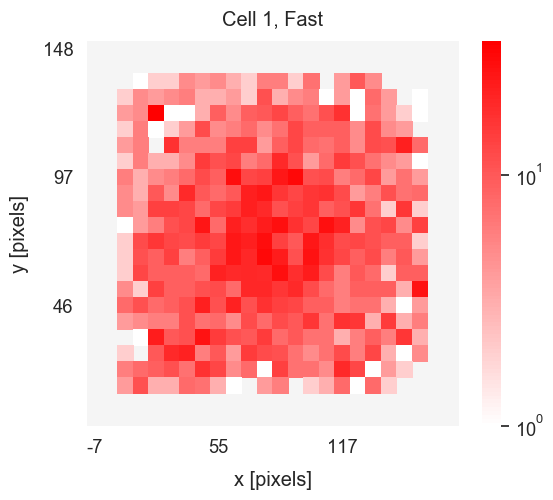

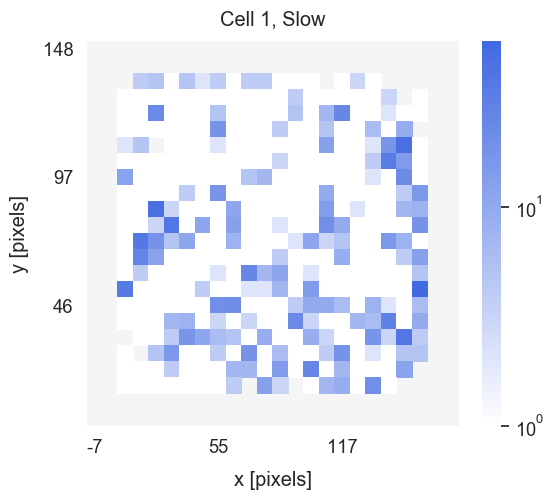

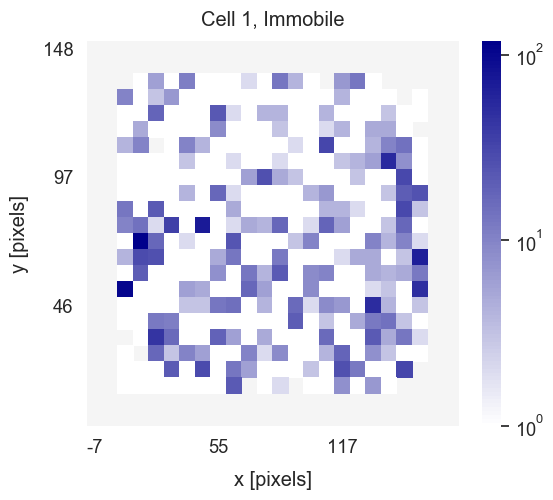

In [25]:
if runProp != filename:
    print('Run section 4 first!')
else:
    print('Folder: ' + str(np.array(foldername)) + ' (' + str(len(filename)) + ' files) \n')
    
    # Select the cell that you want to plot.
    # Counting starts from 0 (exmample: if folder contains 20 files, you can select 0-19).
    selectCell = 0
    
    if selectCell >= len(filename):
        print('Selected cell number is too high! There are only ' + str(len(filename)) + ' files in this folder.')
    else:
        allStatessel = allStates[indices[selectCell]:indices[selectCell + 1]]
        xsel = x[indices[selectCell]:indices[selectCell + 1]]
        ysel = y[indices[selectCell]:indices[selectCell + 1]]
        
        plt.style.use('default')
        plt.rcParams['figure.figsize'] = (6, 5)

        numFeat = 1 + ('meanMSD' in addFeat) * maxOrder + ('xy' in addFeat) * 4

        xhalf0 = []
        yhalf0 = []
        xhalf1 = []
        yhalf1 = []
        xhalf2 = []
        yhalf2 = []

        for i in range(len(allStatessel)):

            for j in range(len(allStatessel[i])):
                if allStatessel[i][j] == 0:
                    xhalf0.append(0.5 * (xsel[i][j] + xsel[i][j + 1]))
                    yhalf0.append(0.5 * (ysel[i][j] + ysel[i][j + 1]))
                elif allStatessel[i][j] == 1:
                    xhalf1.append(0.5 * (xsel[i][j] + xsel[i][j + 1]))
                    yhalf1.append(0.5 * (ysel[i][j] + ysel[i][j + 1]))
                elif allStatessel[i][j] == 2:
                    xhalf2.append(0.5 * (xsel[i][j] + xsel[i][j + 1]))
                    yhalf2.append(0.5 * (ysel[i][j] + ysel[i][j + 1]))


        maxX0 = np.ceil(max(xhalf0))
        maxY0 = np.ceil(max(yhalf0))
        minX0 = np.floor(min(xhalf0))
        minY0 = np.floor(min(yhalf0))
        maxX1 = np.ceil(max(xhalf1))
        maxY1 = np.ceil(max(yhalf1))
        minX1 = np.floor(min(xhalf1))
        minY1 = np.floor(min(yhalf1))
        maxX2 = np.ceil(max(xhalf2))
        maxY2 = np.ceil(max(yhalf2))
        minX2 = np.floor(min(xhalf2))
        minY2 = np.floor(min(yhalf2))

        pad = 2
        gridSize = 20
        grid0 = np.zeros((gridSize + 2 * pad, gridSize + 2 * pad))
        grid1 = np.zeros((gridSize + 2 * pad, gridSize + 2 * pad))
        grid2 = np.zeros((gridSize + 2 * pad, gridSize + 2 * pad))

        for xh0, yh0 in zip(xhalf0, yhalf0):
            grid0[int(np.floor((yh0 - minY0) / (maxY0 - minY0) * gridSize) + pad), \
                  int(np.floor((xh0 - minX0) / (maxX0 - minX0) * gridSize) + pad)] += 1
        for xh1, yh1 in zip(xhalf1, yhalf1):
            grid1[int(np.floor((yh1 - minY1) / (maxY1 - minY1) * gridSize) + pad), \
                  int(np.floor((xh1 - minX1) / (maxX1 - minX1) * gridSize) + pad)] += 1
        for xh2, yh2 in zip(xhalf2, yhalf2):
            grid2[int(np.floor((yh2 - minY2) / (maxY2 - minY2) * gridSize) + pad), \
                  int(np.floor((xh2 - minX2) / (maxX2 - minX2) * gridSize) + pad)] += 1
        
        grid012 = grid0 + grid1 + grid2
        
        
        # For the surface of the whole cell (in cell = 0.01, outside = 0)
        nz = np.nonzero(grid012)
        bg = np.zeros((gridSize + 2 * pad, gridSize + 2 * pad))
        for i, j in zip(nz[0], nz[1]):
            bg[i, j] = 0.01
        
        # For labels with x- and y-coordinates
        skip = 8
        stepx0 = (maxX0 - minX0) / gridSize
        xlabel0 = np.arange(minX0 - pad * stepx0, maxX0 + (pad + 1) * stepx0,  skip * stepx0)
        stepy0 = (maxY0 - minY0) / gridSize
        ylabel0 = np.arange(maxY0 + pad * stepy0, minY0 - (pad + 1) * stepy0, -skip * stepy0)
        stepx1 = (maxX1 - minX1) / gridSize
        xlabel1 = np.arange(minX1 - pad * stepx1, maxX1 + (pad + 1) * stepx1,  skip * stepx1)
        stepy1 = (maxY1 - minY1) / gridSize
        ylabel1 = np.arange(maxY1 + pad * stepy1, minY1 - (pad + 1) * stepy1, -skip * stepy1)
        stepx2 = (maxX2 - minX2) / gridSize
        xlabel2 = np.arange(minX2 - pad * stepx2, maxX2 + (pad + 1) * stepx2,  skip * stepx2)
        stepy2 = (maxY2 - minY2) / gridSize
        ylabel2 = np.arange(maxY2 + pad * stepy2, minY2 - (pad + 1) * stepy2, -skip * stepy2)
        
        sns.set(font_scale = 1.2)
        
        cmap0 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap0', ['white', 'red'], N = 100)
        cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap1', ['white', 'royalblue'], N = 100)
        cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap2', ['white', 'darkblue'], N = 100)

        plt.figure(1)
        cmap = cmap0
        cmap.set_under(color = 'white')
        ax = sns.heatmap(np.flipud(grid0 + bg), norm = LogNorm(grid0.min(), grid0.max()), annot = False, linewidths = 0,\
                         xticklabels = skip, yticklabels = skip, cmap = cmap0, vmin = 1, \
                         cbar_kws = {"ticks":[1, 10, 100]})
        ax.set_xticklabels([int(i) for i in xlabel0], rotation = 0)
        ax.set_yticklabels([int(i) for i in ylabel0], rotation = 0)
        ax.set_facecolor('whitesmoke')
        plt.xlabel('x [pixels]', labelpad = 10, fontsize = 'medium')
        plt.ylabel('y [pixels]', labelpad = 10, fontsize = 'medium')
        plt.title('Cell ' + str(selectCell + 1) + ', Fast', y = 1.02)

        
        plt.figure(2)
        cmap = cmap1
        cmap.set_under(color = 'white')
        ax = sns.heatmap(np.flipud(grid1 + bg), norm = LogNorm(grid1.min(), grid1.max()), annot = False, linewidths = 0,\
                         xticklabels = skip, yticklabels = skip, cmap = cmap1, vmin = 1, \
                         cbar_kws = {"ticks":[1, 10, 100]})
        ax.set_xticklabels([int(i) for i in xlabel1], rotation = 0)
        ax.set_yticklabels([int(i) for i in ylabel1], rotation = 0)
        ax.set_facecolor('whitesmoke')
        plt.xlabel('x [pixels]', labelpad = 10, fontsize = 'medium')
        plt.ylabel('y [pixels]', labelpad = 10, fontsize = 'medium')
        plt.title('Cell ' + str(selectCell + 1) + ', Slow', y = 1.02)
        
        
        plt.figure(3)
        cmap = cmap2
        cmap.set_under(color = 'white')
        ax = sns.heatmap(np.flipud(grid2 + bg), norm = LogNorm(grid2.min(), grid2.max()), annot = False, linewidths = 0,\
                         xticklabels = skip, yticklabels = skip, cmap = cmap2, vmin = 1, \
                         cbar_kws = {"ticks":[1, 10, 100]})
        ax.set_xticklabels([int(i) for i in xlabel2], rotation = 0)
        ax.set_yticklabels([int(i) for i in ylabel2], rotation = 0)
        ax.set_facecolor('whitesmoke')
        plt.xlabel('x [pixels]', labelpad = 10, fontsize = 'medium')
        plt.ylabel('y [pixels]', labelpad = 10, fontsize = 'medium')
        plt.title('Cell ' + str(selectCell + 1) + ', Immobile', y = 1.02)

        
        plt.show()

<a id='Initialization_code_cells'></a>
### Initialization code cells
[Back to code overview](#Code_overview)

#### Checkpoints and font

In [14]:
# Checkpoints
runCompare = 'Nothing'
runProp = 'Nothing'
filename = 'Nothing'
modelName = 'Nothing'
checkClusters = 'Nothing'

In [15]:
# Customized font for graphs
font = {'family' : 'sans-serif',
        'color' : 'k',
        'style' : 'normal', 
        'variant' : 'normal',
        'weight' : 'normal',
        'size' : 'medium'}

#### Importing

In [16]:
import keras
import os
import pickle
import numpy as np
import statsmodels

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import seaborn as sns
import math

import pandas as pd

import scipy

from matplotlib.colors import LogNorm, LinearSegmentedColormap

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

#### Functions

In [ ]:
def getCoord(x, y):
    
    coordXY = []
    
    for trackX, trackY in zip(x, y):
        coxy = []
        
        for j in range(len(trackX) - 1):
            coxy.append([trackX[j], trackY[j], trackX[j + 1], trackY[j + 1]])
        coordXY.append(coxy)
        
    return coordXY

In [ ]:
def getMeanMSDs(x, y, maxOrder, shift):

    D= []
    for trackX, trackY in zip(x, y):
        dTrack = []
        for order in range(1, maxOrder + 1):
            dOrder = []
            for j in range(len(trackX) - order):
                dOrder.append(np.sqrt((trackX[j + order] - trackX[j]) ** 2 + (trackY[j + order] - trackY[j]) ** 2))
            dTrack.append(dOrder)
        D.append(dTrack)

    dVec = []
    for track in D:
        vector = []
        for order in range(1, maxOrder + 1):
            v = []
            dO = track[order - 1]

            for i in range(len(track[0])):
                if order % 2 == 0:
                    iStart = (i - shift - ((order - 1) // 2))
                    iEnd = iStart + (2 * shift) - 1
                else:
                    iStart = (i - shift - (order // 2))
                    iEnd = iStart + (2 * shift)

                if iStart < 0:
                    iStart = 0

                if iEnd > (len(track[0]) - 1):
                    iEnd = len(track[0]) - 1

                meanPoint = np.mean(dO[iStart:(iEnd + 1)])
                v.append(meanPoint)
            vector.append(v)
        dVec.append(vector)

    return dVec

In [ ]:
def getFeatVec(d, x, y, addFeat, maxOrder, shift):
    
    if 'meanMSD' in addFeat:
        dMeanVec = getMeanMSDs(x, y, maxOrder, shift)
        
    if 'xy' in addFeat:
        xy = getCoord(x, y)

    featVec = []
    for i in range(len(d)):
        featTrack = []
        for j in range(len(d[i])):
            featPoint = []
            featPoint.append(d[i][j])

            if 'meanMSD' in addFeat:             
                for order in range(maxOrder):
                    featPoint.append(dMeanVec[i][order][j])

            if 'xy' in addFeat:            
                featPoint.append(xy[i][j][0])
                featPoint.append(xy[i][j][1])
                featPoint.append(xy[i][j][2])
                featPoint.append(xy[i][j][3])

            featTrack.append(featPoint)
        featVec.append(featTrack)
    
    return featVec

In [ ]:
def getDist(x, y, deltaT = 1):    
    
    distances = []

    for trackX, trackY in zip(x, y):        
        distances.append(np.sqrt((np.array(trackX)[deltaT:] - np.array(trackX)[:-deltaT]) ** 2 + \
                                 (np.array(trackY)[deltaT:] - np.array(trackY)[:-deltaT]) ** 2))
        
    return distances

In [ ]:
# Get xy-coordinates (with gap correction)
# For data that was generated using the MtrackJ tool in ImageJ
def loadRealData(filename):
    xCoord = []
    yCoord = []
    trInd = 0
    pos = 0
    
    while trInd <= filename[-1, 3]:
        if trInd == filename[-1, 3]:
            nextt = len(filename)
        else:
            nextt = list(filename[:,3]).index(trInd + 1)

        if nextt - pos > 3:
            frames = filename[pos:nextt, 0]
            xx = filename[pos:nextt, 1]
            yy = filename[pos:nextt, 2]

            missing = list(set(np.arange(frames[0], frames[-1] + 1)) - set(frames))
            if len(missing) != 0:
                missing = sorted(missing)
                xxnew = xx
                yynew = yy
                for i in missing:
                    xxnew = np.insert(xxnew, int(i - frames[0]), np.interp(i, frames, xx))
                    yynew = np.insert(yynew, int(i - frames[0]), np.interp(i, frames, yy))
                xCoord.append(xxnew)
                yCoord.append(yynew)
            else:
                xCoord.append(xx)
                yCoord.append(yy)

        pos = nextt
        trInd += 1
    
    return xCoord, yCoord

In [ ]:
def getMSDandMSS(x, y, numPmsd, numPmss, p, b = 'unknown'):

    # Compute MSD
    dts = np.arange(1, numPmsd + 1)
    timemean = dts - dts.mean()
    sumtsq = sum(timemean ** 2)

    MSD = []
    for dt in dts:
        ddt = getDist(x, y, deltaT = dt)
        flatD = np.asarray([di ** 2 for Ds in ddt for di in Ds])
        MSD.append(flatD.mean())
        
    if b == 'zero':
        diff = np.array(MSD).mean() / dts.mean() * pixSize ** 2 / t / 4
    else:
        diff = sum(timemean * (MSD - np.array(MSD).mean())) / sumtsq * pixSize ** 2 / t / 4

    # Compute MSS
    dts = np.arange(1, numPmss + 1)
    MSS = []

    for pi in p:
        logM = []
        logT = []
        for dt in dts:
            ddt = getDist(x, y, deltaT = dt)
            flatD = np.asarray([di for Ds in ddt for di in Ds])
            logM.append(np.log10((flatD ** pi).mean()))
            logT.append(np.log10(dt))
        logTmean = np.array(logT) - np.array(logT).mean()
        sumLogTsq = sum(logTmean ** 2)
        logMmean = np.array(logM) - np.array(logM).mean()
        MSS.append(sum(logTmean * logMmean) / sumLogTsq)

    # Compute Smss and intercept
    pmean = p - p.mean()
    sumpsq = sum(pmean ** 2)
    MSSmean = np.array(MSS) - np.array(MSS).mean()
    Smss = sum(pmean * MSSmean) / sumpsq
    intercept = np.array(MSS).mean() - Smss * p.mean()

    return diff, MSS, Smss, intercept

In [ ]:
def getMSDandMSSandC(x, y, numPmsd, numPmss, p, b = 'unknown'):

    # Compute MSD
    dts = np.arange(1, numPmsd + 1)
    timemean = dts - dts.mean()
    sumtsq = sum(timemean ** 2)

    MSD = []
    for dt in dts:
        ddt = getDist(x, y, deltaT = dt)
        flatD = np.asarray([di ** 2 for Ds in ddt for di in Ds])
        MSD.append(flatD.mean())
        
    if b == 'zero':
        diff = np.array(MSD).mean() / dts.mean() * pixSize ** 2 / t / 4
    else:
        diff = sum(timemean * (MSD - np.array(MSD).mean())) / sumtsq * pixSize ** 2 / t / 4

    # Compute MSS
    dts = np.arange(1, numPmss + 1)
    MSS = []
    C = []
    cD = []

    for pi in p:
        logM = []
        logT = []
        for dt in dts:
            ddt = getDist(x, y, deltaT = dt)
            flatD = np.asarray([di for Ds in ddt for di in Ds])
            logM.append(np.log((flatD ** pi).mean()))
            logT.append(np.log(dt))
        logTmean = np.array(logT) - np.array(logT).mean()
        sumLogTsq = sum(logTmean ** 2)
        logMmean = np.array(logM) - np.array(logM).mean()
        gamma =  sum(logTmean * logMmean) / sumLogTsq
        MSS.append(gamma)
        C.append(np.array(logM).mean() - gamma * np.array(logT).mean())
        cD.append((np.exp(np.array(logM).mean()) / 2 ** (pi / 2) / scipy.special.gamma(1 + pi / 2)) ** (2 / pi) \
                  / 2 / np.exp(np.array(logT).mean()))

    # Compute Smss and intercept
    pmean = p - p.mean()
    sumpsq = sum(pmean ** 2)
    MSSmean = np.array(MSS) - np.array(MSS).mean()
    Smss = sum(pmean * MSSmean) / sumpsq
    intercept = np.array(MSS).mean() - Smss * p.mean()

    return diff, MSS, C, cD, Smss, intercept

In [ ]:
def getTrackPieces(x, y, allStates):    
    
    piecesX0 = []
    piecesY0 = []
    piecesX1 = []
    piecesY1 = []
    piecesX2 = []
    piecesY2 = []

    for trX, trY, trS in zip(x, y, allStates):
        sw = 0
        pos = 0
        swList = []
        while list(trS)[sw:].count(trS[sw]) != len(trS[sw:]):
            sw = next(ind for ind in range(sw + 1, len(trS)) if trS[ind] != trS[sw])
            if trS[sw - 1] == 0:
                piecesX0.append(trX[pos:sw])
                piecesY0.append(trY[pos:sw])
            elif trS[sw - 1] == 1:
                piecesX1.append(trX[pos:sw])
                piecesY1.append(trY[pos:sw])
            else:
                piecesX2.append(trX[pos:sw])
                piecesY2.append(trY[pos:sw])
            pos = sw
        else:
            if trS[pos] == 0:
                piecesX0.append(trX[pos:])
                piecesY0.append(trY[pos:])
            elif trS[pos] == 1:
                piecesX1.append(trX[pos:])
                piecesY1.append(trY[pos:])
            else:
                piecesX2.append(trX[pos:])
                piecesY2.append(trY[pos:])
            
    return piecesX0, piecesY0, piecesX1, piecesY1, piecesX2, piecesY2

In [ ]:
def getTrackPiecesForInfo(x, y, allStates):    
    
    piecesX0 = []
    piecesY0 = []
    piecesX1 = []
    piecesY1 = []
    piecesX2 = []
    piecesY2 = []
    trnum = 0
    trnums0 = []
    trnums1 = []
    trnums2 = []

    for trX, trY, trS in zip(x, y, allStates):
        sw = 0
        pos = 0
        swList = []
        n = 1
        while list(trS)[sw:].count(trS[sw]) != len(trS[sw:]):
            sw = next(ind for ind in range(sw + 1, len(trS)) if trS[ind] != trS[sw])
            if trS[sw - 1] == 0:
                piecesX0.append(trX[pos:sw])
                piecesY0.append(trY[pos:sw])
                trnums0.append(trnum + n/10)
            elif trS[sw - 1] == 1:
                piecesX1.append(trX[pos:sw])
                piecesY1.append(trY[pos:sw])
                trnums1.append(trnum + n/10)
            else:
                piecesX2.append(trX[pos:sw])
                piecesY2.append(trY[pos:sw])
                trnums2.append(trnum + n/10)
            pos = sw
            n += 1
        else:
            if trS[pos] == 0:
                piecesX0.append(trX[pos:])
                piecesY0.append(trY[pos:])
                trnums0.append(trnum + n/10)
            elif trS[pos] == 1:
                piecesX1.append(trX[pos:])
                piecesY1.append(trY[pos:])
                trnums1.append(trnum + n/10)
            else:
                piecesX2.append(trX[pos:])
                piecesY2.append(trY[pos:])    
                trnums2.append(trnum + n/10)
        trnum += 1
            
    return piecesX0, piecesY0, piecesX1, piecesY1, piecesX2, piecesY2, trnums0, trnums1, trnums2

In [ ]:
def patchmatch(match, pattern):
    indices = []
    for pat in pattern:
        found = False
        patlen = len(pat)
        for i in range(len(match)):
            rollAr = np.roll(match, -i)
            if rollAr[:patlen].tolist() == pat:
                ind = np.arange(i, i + patlen)
                found = True
                break
        if found == False:
            print('No match for %s' %(pat))
        else:
            indices.append(ind.tolist())
            
    return indices

In [ ]:
# execution of initialization cells is done
initialization_bar.value += 1